##  Give an overview of the types of operations that a Bloom filter supports, and where Bloom filters might be useful

Bloom filters are space-efficient randomized data structures for fast membership queries. A Bloom filter uses $\textbf{m}$ bits to represent $\textbf{n}$ elements by using $\textbf{k}$ independent hash functions, with the false positive rate $\textbf{pf}$. Bloom filters allow false positives when querying an element, that is, returning true when the element is not in the set, but not false negatives, that is, returning false when the element is not in the set. 

In this assignment, I will use Counting Bloom Filter: 

Counting Bloom Filters (CBFs) perform the same operations on dynamic sets that can be updated via insertions and deletions. CBF extends Bloom filters by using a fixed-size counter instead of a single bit for each entry in the vector. When an element is inserted into CBF, the corresponding counters are incremented; deletions can now be safely done by decrementing the counters. To avoid counter overflow, we choose four bits per counter for most applications. 

Bloom filters have found widespread applications in databases, network applications, and distributed systems. Because of its characteristics, bloom filters are suitable for a number of applications where a small probability of getting false positives is fine as long as we don’t get any false negatives (e.g. check whether a specific item is in the storage or not; Keep track of the pages that a given user has visited without actually store every URL they visited; representing your contact list to suggest adding new contacts, etc.). One specific example is within the storage of Amazon of over 564 million products. If we need the false positive rate $fp = 0.001$, we can use 8.1 billion slots $m=8.1$ (billion), with 10 hash functions $k=10$. We first use bloom filter to check if the item is in the database. If no, we don't need to check any further. Else, we can perform other type of search (binary search, etc.) to double-check whether the item is in the database. The benefits of using Bloom filter is when it resulted in "item not in the database", which we are certain that it will not be in the database, hence, no further search needed -> efficient compared to having to do binary search every times we need to check an item.

The benefits of using counting bloom filter is the deletion function. If you know for sure that an element is in the list and you want to delete it, you can do it by get its position by using $k$ hash functions. Then delete each position by 1, which will demonstrate the deletion. For example, in Amazon store, after knowing the item might be in the storage by using bloom filter, the manager run a binary search to find the item. After which, the item is sold and permanently deleted from the storage. Hence, we can use the deletion advantage of counting boom filter. For standard boom filter, you cannot perform deletion as you don't know whether that slot only belongs to the removed items or is it also the hashes of other elements. The deletion function will also be demonstrated below.

## Implement a Bloom filter.

### Import important functions

In [19]:
# import libraries for later use
import string # for creating input
import random # for randomizing input
import math # for math use
import numpy as np # for numerical processing
import matplotlib.pyplot as plt #for plotting

### Create data

In [20]:
def create_string():
    size_of_element = random.randint(1,6)
    # first choose the length of the word: a random length between 1 and 6
    
    # all possible allowed characters (digits or lowercase)
    characters = string.digits + string.ascii_lowercase
    
    #create an output word
    output = '' 
    # create a random word with the length outputted above
    for i in range(size_of_element): 
        # choose a random element in the set of all possible characters
        output += random.choice(characters)
    return output

### Transform data from string type into integer type

In [21]:
# data encryption: we want to deal with number
# change string into number

# This is all possible allowed characters (digits or lowercase)
combination = string.digits + string.ascii_lowercase

# the dictionary in the list of all possible characters
# one nice thing about this dictionary is the index of the elements
### is exactly its encoded value
dictionary = []
for i in combination:
    dictionary.append(i)
    

def input_to_number(x):
    # the parameter is the data we need to encode to numbers
    x = str(x)
    output = 0
    # go through the length of the string:
    for i in range(len(x)):
        # As we are using base 36 
        ### -> multiply each element by 36^(its order in the original string)
        output += dictionary.index(x[i])*(36**i)
    return output

### Hash functions and encrypt the location for each element

In [22]:
# find prime for the universal hash
def find_prime():
    # find the smallest prime number > 2**32 
    # the reason for 2**32 is because 
    ### 2**32 > input_to_number("zzzzzz")
    # the prime must be odd, so I chose a random odd number
    p = random.randrange(2**32 + 1, 2**34 + 1, 2)
    while True:  
        # check if it is a prime by checking possible divisors
        # the divisors range from 3 to sqrt(p)
        if all(p % i != 0 for i in range(3, int((p ** 0.5) + 1), 2)):
            # all the odd number less than of equal sqrt p
            break  
        # if not prime
        else: 
            # increase by 2 (maintain the odd properties)
            p += 2
    return p

# as the definition of our hash functions
# choose the coefficient: a in [1, p-1], b in [0,p-1]
def hash_coefficient(p):
    a = random.randint(1, p-1)
    b = random.randint(0, p-1)
    return [a,b]

# create the hash functions
def create_hash_function(k):
    # the parameters is the number of hash functions we need
    # create hash_family as the functions
    hash_family = []
    for i in range(k):
        # find the prime number
        p = find_prime()
        # find the coefficient
        coefficient = hash_coefficient(p)
        # append the prime number
        coefficient.append(p)
        # append this hash function into the family of hash functions
        hash_family.append(coefficient)
    return hash_family

# the location of element after using hash functions
def encrypt_variables(x):
    location = []
    for i in hash_function:
        # use each hash function in the hash families
        # hash: ((a*x + b) mod p) mod m
        location.append(((i[0] * x + i[1]) % i[2]) % m)
    return location

### Bloom filter functions (insert, import, delete, and check)

For bloom filter, I will implement 4 different functions: (and I will base my reasoning on the amazon storage example)

insert_element: this function will prepare for the bloom_filter to accept new input. This is neccessary because when need to keep updating, changing our dataset with new inputs instead of only working with 1 initial dataset. For example, Amazon cannot only keep track of the items in storage already, they need to add new items.

import_element: this function will cope with the initial state and situations of importing large amount of items. For example, at the beginning, before using bloom filter, Amazon already has a storage full of items already. Hence, we need to use those data to import directly into bloom filter. 

delete_element: this function is the benefit of the counting bloom filter. As Amazon buy and sell a lot. If we only have the insert function, then the data structure will be overwhelm at some point. Hence, we use counting boom filter to cope with situations those Amazong sell items permanently. 

check_element: this function will resulted in the item is in the storage or not, with a certain false positive rate. This is neccessary because we can save more time $O(k)$ with k in the number of hash functions to access 1 item in the storage or not. If we use binary search or other search functions, it might get $O(\log (n))$, which is larger than $k$ if $n$ is really big, which is true in the case of Amazon

In [48]:
# insert function: insert new element
def insert_element(bloom_filter,x):
    # take 2 parameters: bloom_filter and new element
    # transform the input to number
    new_input = input_to_number(x)
    # find the locations of the "x" element after hashing
    encryption = encrypt_variables(new_input)
    # each location will be added by 1
    for k in encryption:
        bloom_filter[k] += 1
    return bloom_filter

def import_element(bloom_filter,import_data):
    # take 2 parameters: bloom_filter and the import_data
    # import_data will be a list in this scenario
    # the reason for this function is because we might want to 
    ### import the whole data from a lists/database instead of each element separately
    # the way doing this is simply use the insert_element function
    for x in import_data:
        insert_element(bloom_filter, x)
    
    
# delete function: delete existed element
def delete_element(bloom_filter,x):
    # take 2 parameters: bloom_filter and deleted element
    # transform the input to number
    remove_element = input_to_number(x)
    # find the locations of the "x" element after hashing
    encryption = encrypt_variables(remove_element)
    # each location will be decreased by 1
    for k in encryption:
        bloom_filter[k] -= 1
    return bloom_filter

# check function: check if an element in the database
def check_element(bloom_filter, x):
    # take 2 parameters: bloom_filter and the element we want to check
    # transform the input to number
    check_element = input_to_number(x)
    # find the locations of the "x" element after hashing
    encryption = encrypt_variables(check_element)
    product_hash = 1
    for k in encryption:
        # We need to check if there is any 0 in the locations
        # Using the product of those location is efficient
        product_hash *= bloom_filter[k]
    if product_hash == 0:
        # exist at least 1 slot has the value 0 in x's locations
        return False
    else:
        # all x's locations > 0
        return True

### Implement and test Boom filter

#### Test challenge

In [49]:
def working_test(bloom_filter, list_of_input, number_of_tests):
    # take 3 parameters: bloom_filter, original input, and the number of test running
    # create your testing cases
    test_cases = []
    # create "number_of_tests test" cases
    for i in range(number_of_tests):
        test_cases.append(create_string())
    
    # for each cases 
    for i in test_cases:
        # see if the element is in the database using bloom filter
        result = check_element(bloom_filter, i)
        
        # positive
        if result: 
            # true positive
            if i in list_of_input:
                print("Positive", end = ' --- ')
            # false positive
            else: 
                print("False Positive", end = ' --- ')
                
        # true negative
        else:
            print("Negative", end = ' --- ')
            
    # I print as above as I don't want to make my output clustered
            

#### Implement

In [52]:
# Set the storage as 1000
# Set the number of input to 100
hash_function = []
m = 1000
n = 100

# this is the function to check if the bloom filter works
def bloom_filter_check(k):
    # the parameter is the number of hash functions we want
    # the reason we want this variable to be global is to be easier 
    ### to impliment in the encryptions and other functions
    global hash_function
    
    # create the list of inputs
    list_of_input = []
    bloom_filter = [0]*m
    for i in range(n):
        list_of_input.append(create_string())
    
    # create the hash functions
    hash_function = create_hash_function(k)
    
    # insert the list_of_input into the empty bloom filter
    import_element(bloom_filter,list_of_input)
    # We can also try the insert_element function:
    insert_element(bloom_filter, "cs110")
        
    # check for 100 test cases and return the result of whether  
    ### that element is in the list or not
    working_test(bloom_filter, list_of_input, 100)

In [53]:
# run the test cases for 3, 5, 7 hash functions
bloom_filter_check(3)
print('')
print('')
bloom_filter_check(5)
print('')
print('')
bloom_filter_check(7)

Negative --- Positive --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- False Positive --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Positive --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Positive --- Negative --- Positive --- Negative --- Negative --- Positive --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negative --- Negati

### Test the deletion function

In [55]:
# this is only to demonstrate the deletion use
# deletion is the special benefits of counting bloom filter

hash_function = []
def bloom_filter_deletion(k):
    # the reason we want this variable to be global is to be easier 
    ### to impliment in the encryptions and other functions
    global hash_function
    
    # create the list of inputs
    list_of_input = []
    bloom_filter = [0]*m
    for i in range(n):
        list_of_input.append(create_string())
    
    # create the hash functions
    hash_function = create_hash_function(k)
    
    # insert the list_of_input into the empty bloom filter
    import_element(bloom_filter,list_of_input)
    # We can also try the insert_element function:
    print(bloom_filter)
    print('')
    print('')
    
    # now we delete the element we know that is in the list
    for x in list_of_input:
        # delete each element
        delete_element(bloom_filter, x)
    print(bloom_filter)
    print('')
    print('')
    
    # we can try with a specific key
    insert_element(bloom_filter, "cs110")
    print(bloom_filter)
    print('')
    print('')
    # and then delete it
    delete_element(bloom_filter, "cs110")
    print(bloom_filter)       
    

bloom_filter_deletion(5)

[0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 3, 1, 0, 1, 1, 0, 0, 0, 0, 3, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 2, 1, 0, 2, 0, 2, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 

## Give a description of the hash functions that your implementation uses.

### Hash function

As I want to build the ideal $k$ number of hash functions based on the input $m$ and $n$, hence, I need to build generic hash functions. The approach is called "universal hashing".

Let $H$ be a finite collection of hash functions that map a given universe $U$ of keys into the range $\{0, 1, ..., m-1\}$. Such a collection is said to be "universal" if for each pair of distinct keys $k$, $l$ $\in$ $U$, the number of hash functions $h \in H$
for which $h(k) = h(l)$ is at most $H/m$. In other words, with a hash function randomly chosen from $H$, the chance of a collision between distinct keys $k$ and $l$ is no more than the chance $1/m$ of a collision if $h(k)$ and $h(l)$ were randomly and independently chosen from the set $\{0, 1, ..., m-1\}$

Here is the hash function: Choose a prime number $p$ large enough so that every possible key $k$ is in the range $0$ to $p-1$, inclusive. Let $Z_p$ denote the set $\{0, 1, ..., p-1\}$, and let $Z_p^\ast$ denote the set $\{1, 2, ..., p-1\}$. Because we assume that the
size of the universe of keys is greater than the number of slots in the hash table, we have $p>m$.

The hash function: For any $a \in Z\ast$ and $b \in Z$, using a
linear transformation followed by reductions modulo $p$ and then modulo $m$: $$h_{ab}(x) = ((ax + b) \; mod \: p) \; mod \: m $$ 
We say the created hash function is universal because: Consider two distinct keys $k, l \in Z_p$, so that $k \ne l$. For a given
hash function $h_{ab}$ we let: 
$$r = (ak + b) \: mod \: p$$ 
$$s = (al + b) \: mod \: p$$
We have: $r \ne s$ because $r - s = a(k-l) \: mod \: p$. If $r=s$ $\Rightarrow$ $a(k-l)=0 \: mod \: p$. As $p$ is a prime, both $a$ and $k-l$ are nonzero mod $p$, and so their product must also be nonzero mod $p$, contradict $a(k-l)=0 \: mod \: p$. Hence, $r \ne s$.

Therefore, when computing any $h_{ab} \in H$ , distinct inputs $k$ and $l$ map to distinct. values $r$ and $s$ mod $p$; there are no collisions yet at the “mod $p$ level.” Moreover, each of the possible $p(p-1)$ choices for the pair $(a,b)$ with $a\ne 0$ yields a different
resulting pair $(r,s)$ with $r \ne s$, since we can solve for $a$ and $b$ given $r and $s:
$$a = ((r-s)((k-l)^{-1} \: mod \: p)) \: mod \: p$$
$$b = (r - ak) \: mod \: p$$
where $(k-l)^{-1} \: mod \: p$ denotes the unique multiplicative inverse, mod $p$ of $k-l$: $(k-l)(k-l)^{-1} = 1 \: mod \: p$.

Since there is a one-to-one correspondence between pairs $(a,b)$ with $a \ne 0$ and pairs $(r,s)$ with $r\ne s$ - "bijection". Thus, for any given pair of inputs $k$ and $l$, if we pick $(a,b)$ uniformly
at random, the resulting pair $(r,s)$ is equally likely to be any pair of distinct values mod $p$.

Therefore, the probability that distinct keys $k$ and $l$ collide is equal to the probability that $r=s \: mod \: m$ when $r$ and $s$ are randomly chosen as distinct values mod $p$. As $p$ and $m$ are independent, $r$ and $s$ will be chosen as random values mod $m$. The chance for collisions is $1/m$. Hence, $H$ is universal. $H$ hash functions will create a uniform random distribution as the chance for collisions is $1/m$. 

To increase randomization, we can also regenerate a different value of the prime number $p$ for each hash function. With the randomization of $p$, the coefficient $a,b$, we will create $k$ hash functions those are independent and all create uniform random distribution.

(proof was partially retrieved from Cormen et al.)

### Input_to_number function

As I want my bloom filter to work both on numbers and letters, I need a function to convert string to number. To restrict the type of input, I only allow a less-than-7-character input contains only lowercase characters and digits. As we have 10 digits $(0-9)$ and 26 letters, I propose using a base-36 (hexatridecimal) numerical system  is a positional numeral system using 36 as the radix. This type of encryption will create a unique output for an input and also vice versa - bijection. Also, this type of encryption will save memories and avoid collisions. Its output range from $0$ to $2176782335$ (this is the smallest case: $0$ and the biggest case: "zzzzzz"), and all output maps back to 1 distinct input. No spared/unused number or collisions. The detailed was described in the code.

### Input restriction to fit the encrytion and hash functions

In the implementation, as we restrict the input to be a less-than-7-character words (whether number of lowercase letter). In the definition of the hash functions, we mentioned the need for choosing a prime number $p$ large enough so that every possible key $k$ is in the range $0 \rightarrow p-1$, inclusive. Hence, $p > 2176782335$ (the  biggest case of less-than-7-character). As $32 > log_2(2176782335) > 31$. Hence, we can set $p$ to be a random prime larger than $2^{32}$. This will guarantee the property of the hash function

## Provide an analysis of how your implementation scales in terms of:

For counting blooming filter, there is no difference from the standard bloom filter in the relationship between false positive rate, the stored input, and the number of hashes. As the counting bloom filter only has 1 significant improvement is the deletion function. The remaining variables stay the same. The memory size might need to be bigger (As we are not storing 0 or 1, but we are storing an interger). However, in the scope of this assignment, we can consider both types of filters have the same memory size

Notes: in real life, we can consider 1 slot has maximum 4 bits to store (up to 15 - "1111"). Hence, if given the number of bits, divide by 4 will be the number of slots in the array. 

In this assignment, the memory size will be understood as the number of slots initially in the bloom filter. 

As the similarity to the standard boom filter, we still have several key findings: 
$$pf \approx (1-e^{-kn/m})^k$$
For optimal cases: 
$$k=\frac{m}{n} \ln 2$$
$$\frac{m}{n} = -\frac{\log_2 pf}{\ln 2}$$
$$k = -\frac{\ln pf}{\ln 2} = \log_2 p$$

### Memory size as a function of the false positive rate

If we use the generic formula: 
$$pf \approx (1-e^{-kn/m})^k$$

When we fixate $n,k$, we have:
$$log_k(pf) = 1-e^{-kn/m}$$
$$\Rightarrow e^{-kn/m} = 1 - log_k(pf)$$
$$\Rightarrow -kn/m = \ln(1 - log_k(pf))$$
$$\Rightarrow -m/kn = log_{1 - log_k(pf)}e$$
$$\Rightarrow m = -kn*log_{1 - log_k(pf)}e$$
This is the memory size $m$ as a function of the false positive rate $pf$, given $n$ and $k$ as constant

When we want $pf$ to decrease $\rightarrow$ $(1-e^{-kn/m})^k$ decreases $\rightarrow$ $1-e^{-kn/m}$ decreases (as $k$ is a positive integer) $\rightarrow$ $e^{-kn/m}$ increases $\rightarrow$ $-kn/m$ increases $\rightarrow$ $kn/m$ decreases $\rightarrow$ $m$ increases.

This is plausible as the more slots we use, along with the uniform distribution of the output of the hash functions, we will have less collisions, which is good $\rightarrow$ $pf$ decreases

If we assume the function will create the ideal number of hash functions for every input given, we will have: $\frac{m}{n} = -\frac{\log_2 p}{\ln 2}$. 

Fixate the number of input $n$. Then, follow by the optimal number of bits per element formula: 
$$\Rightarrow m = -\frac{n\ln (pf)}{(\ln 2)^2}$$
As $-\frac{n}{(\ln 2)^2}$ is a constant when we fixate $n$ $\Rightarrow$ $m = O(\log (pf))$

We can see $m = -\frac{n\ln (pf)}{(\ln 2)^2}$, which implies when $pf$ decreases and $pf$ < 1, $\ln pf$ is negative and decreases, which make $-\ln pf$ positive and increases, making $m$ increases: consistent with the finding above.

### Memory size as a function of the number of items stored

If we use the generic formula: 
$$pf \approx (1-e^{-kn/m})^k$$

When we fixate $pf,k$, we have:
$$log_k(pf) = 1-e^{-kn/m}$$
$$\Rightarrow e^{-kn/m} = 1 - log_k(pf)$$
$$\Rightarrow -kn/m = \ln(1 - log_k(pf))$$
$$\Rightarrow -m/kn = log_{1 - log_k(pf)}e$$
$$\Rightarrow m = -kn*log_{1 - log_k(pf)}e$$
As $-k*log_{1 - log_k(pf)}e$ is constant when we fixate $pf$ and k $\Rightarrow$  $m = O(n)$
This is the memory size $m$ as a function of the the number of items stored $n$, given $pf$ and $k$ as constant

We have: as $k$ is positive, $log_{1 - log_k(pf)}e$ is negative because $0 < 1 - log_k(pf) < 1$, therefore, $-k*log_{1 - log_k(pf)}e$ is a positive constant. Hence, when $n$ increases, $m = -kn*log_{1 - log_k(pf)}e$ will implies $m$ increases

This is plausible as the more number of inputs we stored, if we wish to maintain the number of hash functions and the false positive rate, along with the uniform distribution of the output of the hash functions, we will need more spaces to have less collisions.

If we assume the function will create the ideal number of hash functions for every input given: $k = \frac{m}{n}\ln 2$. 

Fixate the desired false positive rate $pf$. Then, follow by the optimal number of bits per element formula: 
$$\frac{m}{n} = -\frac{\log_2 pf}{\ln 2}$$
As $-\frac{\ln (pf)}{(\ln 2)^2}$ is a positive constant when we fixate $pf$ and we know $ pf < 1$ $\Rightarrow$  $m = O(n)$

When $n$ increases $\rightarrow m$ increases: consistent with the finding above.

### Access time as a function of the false positive rate

For access time: Each time if we want to check if the element is in the list or not, we must go through k hash functions. Hence, the access time is linear to the number of hash functions: $O(k)$

As representing the access time as a function of the false positive rate: we have: assuming we have the ideal $k$: value of $k$ that minimizes the false positive probability
$$k = \frac{m}{n}\ln 2$$
$$\frac{m}{n} = -\frac{\log_2pf}{\ln 2} $$
$$\Rightarrow k = -\frac{\ln pf}{\ln 2} = -log_2 pf$$
Hence, the ideal access time is $O(log(pf))$

In general cases, when we fixate $m, n$, the function of how $k$ relates to $pf$ would be a curve, where exist a minima at $k = -log_2 pf$. The $pf$ will decrease on the interval $[1,-log_2 pf]$ and increases on the interval $[-log_2 pf, \infty]$. The ideal $k$ is the value between $\lceil k \rceil$ and $\lfloor k \rfloor$, whichever yields the smaller $pf$.

The curve will be presented in the last session as the function of expected false positive rate with respect to $k$, given fixed $m$ and $n$.

### Access time as a function of the number of items stored

For access time: Each time if we want to check if the element is in the list or not, we must go through k hash functions. Hence, the access time is linear to the number of hash functions: $O(k)$

As representing the access time as a function of the number of items stored: we have: assuming we have the ideal $k$: value of $k$ that minimizes the false positive probability
$$k = \frac{m}{n}\ln 2$$
Then when we fixate $m$, then we have the inverse relation between $k$ and $n$: $k = O(n^{-1})$

The reason for this inverse relation is because: when we have limited memory size - limited slots, if we increase the number of hash functions, then it will create more clusters in the bloom filter as there are so many occupied slots already, hence, will increase the false positive rate. Therefore, with limited memory and a desired positive rate, the more input, the less number of hash functions we need.

In my implementation, as I fixed $m$ and $n$ originally and let $k$ runs. Then we check an new input, it has to go through $k$ hash functions $O(k)$ and check with the output. The number of items stored initially $n$ does not affect the checking time of a new input. In my implementation, the number of items stored $n$ is independent with the access time $k$ as I already fixed $n$

## Produce a plot to show that your implementation’s false positive rate matches the theoretically expected rate.

Test the relation between the number of hash functions and the false positive rate, given fixed m, n

In [61]:
hash_function = []
m = 1000
n = 100
def bloom_filter_fp_check(k):
    # the parameter is the number of hash functions we want
    # the reason we want this variable to be global is to be easier 
    ### to impliment in the encryptions and other functions
    global hash_function
    
    # create the list of inputs
    list_of_input = []
    bloom_filter = [0]*m
    for i in range(n):
        list_of_input.append(create_string())
    
    # create the hash functions
    hash_function = create_hash_function(k)
    
    # import the data into the bloom filter
    import_element(bloom_filter, list_of_input)
    
    # return the function calculating the false positive rate for 1000 test cases
    return false_positive_test(bloom_filter, list_of_input, 1000)

In [62]:
# this is the function for calculating the false positive rate
def false_positive_test(bloom_filter, list_of_input, number_of_tests):
    # take 3 parameters: bloom_filter, original input, and the number of test running
    # create the testing cases
    test_cases = []
    # create "number_of_tests test" cases
    for i in range(number_of_tests):
        test_cases.append(create_string())
    
    # negative is the number of input those not in the original list
    # False positive is the number of input those not in the original list 
    ### but return positive
    negative = 0
    false_positive = 0
    
    # running all elements in the test cases
    for i in test_cases:
        # get the result from the check_element function
        result = check_element(bloom_filter, i)
        
        # if the input not in the original list: negative case
        if i not in list_of_input: 
            # plus 1 to negative
            negative += 1
            # if the result of the check_element is True --> false positive
            if result == True:
                # false positive + 1
                false_positive += 1
    # the false positive rate is the number of false positive cases over all negative cases        
    return false_positive/(negative)

In [63]:
# this is the theoretical result given by the reading

def theoretical(k):
    return (1 - np.e**(-k*n/m))**k

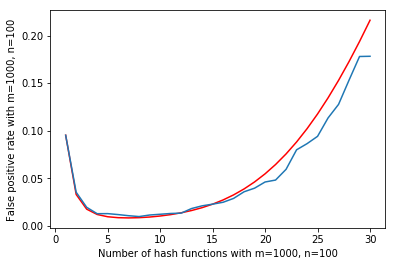

In [87]:
m = 1000
n = 100
# As we will run for at least 30 cases, we need to keep track of the data

# this is the tracking of the number of hash functions we will use
index = []
# this is the tracking for the simulation data
avg_fp_simulation = []
# this is the tracking for the theoretical result
theoretical_result = []

# run the test with the number of hashes from 1 to 30
for k in range(1,31):
    # append the number of hash functions we used
    index.append(k)
    # append the theoretical results we yield
    theoretical_result.append(theoretical(k))
    
    # for simulation, we will run the test 30 times
    # this will ensure the randomness of the sampling and mitigate biases
    sampling = []
    for i in range(30):
        # append the result of 30 times sampling
        
        sampling.append(bloom_filter_fp_check(k))
    # we only append the average of these results to the simulation results
    avg_fp_simulation.append(np.mean(sampling))

# plot the results, with the number of hashes as the x-axis, positive rate as the false positive rate
# theoretical result is red line, the simulation is the blue line
plt.plot(index, theoretical_result,color='red')    
plt.plot(index, avg_fp_simulation)
plt.xlabel('Number of hash functions with m=1000, n=100')
plt.ylabel("False positive rate with m=1000, n=100")
plt.show() 



In [89]:
print("simulations: k yields the lowest pf" ,index[avg_fp_simulation.index(min(avg_fp_simulation))])
print("theoretical: k yields the lowest pf" ,index[theoretical_result.index(min(theoretical_result))])

simulations: k yields the lowest pf 7
theoretical: k yields the lowest pf 7


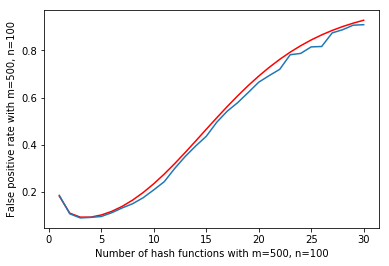

simulations: k yields the lowest pf 3
theoretical: k yields the lowest pf 3


In [77]:
m = 500
n = 100

# As we will run for at least 30 cases, we need to keep track of the data

# this is the tracking of the number of hash functions we will use
index = []
# this is the tracking for the simulation data
avg_fp_simulation = []
# this is the tracking for the theoretical result
theoretical_result = []

# run the test with the number of hashes from 1 to 30
for k in range(1,31):
    # append the number of hash functions we used
    index.append(k)
    # append the theoretical results we yield
    theoretical_result.append(theoretical(k))
    
    # for simulation, we will run the test 30 times
    # this will ensure the randomness of the sampling and mitigate biases
    sampling = []
    for i in range(30):
        # append the result of 30 times sampling
        
        sampling.append(bloom_filter_fp_check(k))
    # we only append the average of these results to the simulation results
    avg_fp_simulation.append(np.mean(sampling))

# plot the results, with the number of hashes as the x-axis, positive rate as the false positive rate
# theoretical result is red line, the simulation is the blue line
plt.plot(index, theoretical_result,color='red')    
plt.plot(index, avg_fp_simulation)
plt.xlabel('Number of hash functions with m=500, n=100')
plt.ylabel("False positive rate with m=500, n=100")
plt.show()  

print("simulations: k yields the lowest pf" ,index[avg_fp_simulation.index(min(avg_fp_simulation))])
print("theoretical: k yields the lowest pf" ,index[theoretical_result.index(min(theoretical_result))])

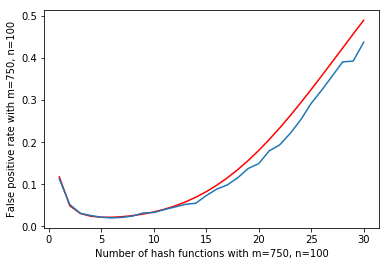

simulations: k yields the lowest pf 6
theoretical: k yields the lowest pf 6


In [83]:
m = 800
n = 100
# As we will run for at least 30 cases, we need to keep track of the data

# this is the tracking of the number of hash functions we will use
index = []
# this is the tracking for the simulation data
avg_fp_simulation = []
# this is the tracking for the theoretical result
theoretical_result = []

# run the test with the number of hashes from 1 to 30
for k in range(1,31):
    # append the number of hash functions we used
    index.append(k)
    # append the theoretical results we yield
    theoretical_result.append(theoretical(k))
    
    # for simulation, we will run the test 30 times
    # this will ensure the randomness of the sampling and mitigate biases
    sampling = []
    for i in range(30):
        # append the result of 30 times sampling
        
        sampling.append(bloom_filter_fp_check(k))
    # we only append the average of these results to the simulation results
    avg_fp_simulation.append(np.mean(sampling))

# plot the results, with the number of hashes as the x-axis, positive rate as the false positive rate
# theoretical result is red line, the simulation is the blue line
plt.plot(index, theoretical_result,color='red')    
plt.plot(index, avg_fp_simulation)
plt.xlabel('Number of hash functions with m=750, n=100')
plt.ylabel("False positive rate with m=750, n=100")
plt.show() 

print("simulations: k yields the lowest pf" ,index[avg_fp_simulation.index(min(avg_fp_simulation))])
print("theoretical: k yields the lowest pf" ,index[theoretical_result.index(min(theoretical_result))])

Interpretations: As we can see for 3 random test cases (m=1000, n=100), (m=500, n=100), (m=750, n=100), we can see the simulations yield a matching result with the theoritical result. The reason why I didn't random sampling m,n into 30 test cases is because m,n has constraints, and will immediate affect running time. Also, different m, n can yield very diverse false positive rate (e.g. m=1000, n=10 vs m=1000, n=200). Hence I restricted to 3 test cases. However, with each test cases, random sampling of 30 sub-tests have already been performed. Furthermore, as the conditions I gave for the graph is to demonstrate the relation between $pf$ and $k$, hence, fixing m,n is valid. 

We can also see that the $k$ yields the minimal $p$ is around $\frac{m}{n} \ln 2$ 
$$m=1000, n=100 \rightarrow k = 6.9 \rightarrow k=6 \: or \: k=7 \rightarrow  \: simulation \: and \:  theoretical \:  results \:  matched\:  : k=7$$
$$m=500, n=100 \rightarrow k = 3.5 \rightarrow k=3 \: or \:  k=4 \rightarrow  \: simulation \: and \:  theoretical \:  results \:  matched\:  : k=3$$
$$m=800, n=100 \rightarrow k = 5.5 \rightarrow k=5 \: or \: k=6 \rightarrow  \: simulation \: and \:  theoretical \:  results \:  matched\:  : k=6$$

### Appendix

$\#$dataviz: This work contains multiple appropriate data visualization with effective data storage, color coding, and variables chosen. I also effectively analyzes and interprets a data visualization and provide appropriate justification and details to back up my arguments. The graphs also have clear labels.

$\#$sampling: In this work, the student understand that he need to create appropriate sampling to test the codes. Hence, the student decided to use random sampling (using random library and then use string library to create random combination of words), then choose a sampling size of 30 to mitigate biases (and can plausibly approximate normal distribution). This is a deep knowledge of #sampling in testing cases.

$\#$modelling: The student models, simulates the bloom filter, with different test cases and the interpretation of the modelling. The student also explains patterns in empirical data: the match and also the optimal $k$, where the student yields a matching result for simulation and theoretically. This has demonstrated a strong application of $\#$modelling

$\#$algorithms: strong application of the algorithms by using counting bloom filter and building universal hash functions based on deep knowledge of number theory.

$\#$gapanalysis: identify the constraints of the current bloom filtering (cannot delete items), identify the goal state of being able to delete items. Hence, the counting bloom filter was selected and implemented by the student. This is a strong application of #gapanalysis because the students evaluates the effectiveness of existing problem (stadard bloom filter) and provides appropriate justification for the evaluation with graphs and details on optimal $k$ value for lower $pf$)